In [1]:
import os
import sys
sys.path.append(os.path.dirname(os.path.realpath('../ux')))

from ux.jupyter_imports import *
import copy

In [2]:
dirname = os.path.join(os.sep, 'tmp','pfoptimizer')
#dirname = os.path.join(os.sep, 'user','david', 'Documents', 'basisprez', 'BTC 5bps')

original_pnl = pd.read_csv(os.path.join(os.sep, dirname,'pnl.csv'), 
                           date_parser=parser.parse, 
                           parse_dates=['end_time'],
                           index_col=0)
original_trajectory = pd.read_csv(os.path.join(os.sep, dirname,'trajectory.csv'),
                            date_parser=parser.parse, 
                            parse_dates=['time'],)
original_history = pd.read_csv(os.path.join(os.sep, dirname,'history.csv'), 
                               date_parser=parser.parse, 
                               index_col=0)
equity = 1e7

In [3]:
end = datetime.now().replace(tzinfo=timezone.utc)
start = end - timedelta(days = 365)
pnl = original_pnl[(original_pnl['end_time']>start)&(original_pnl['end_time']<end)]

carry = pnl[pnl['bucket']=='carry(USD not annualized)'].drop(columns='bucket')
carry['amtUSD'] *= 1e4/equity # in bps

weights = pnl[pnl['bucket']=='weights'].drop(columns='bucket')
weights['amtUSD'] /= equity

IR01 = pnl[pnl['bucket']=='IR01(USD)'].drop(columns='bucket')
IR01['amtUSD'] *= 1e4/equity # in bps

tx_cost = pnl[pnl['bucket']=='tx_cost(USD not annualized, fwd)'].drop(columns='bucket')
tx_cost['amtUSD'] *= 1e4/equity # in bps

# Excess return in bps
## assumes spreads are done at mid every funding period
## Pls note there is no hyperparamters (so no overfit here)
### * carry = funding-borrow
### * IR01 = spot*premium chg
### * delta = 0 (only exists during exec)

In [4]:
carry_cum = carry.pivot_table(index='end_time',columns='name',values='amtUSD').cumsum()
IR01_cum = IR01.pivot_table(index='end_time',columns='name',values='amtUSD').cumsum()
tx_cost_cum = tx_cost.pivot_table(index='end_time',columns='name',values='amtUSD').cumsum()
IR01_cum

name                         ADAUSDT   ATOMUSDT   BCHUSDT    BNBUSDT  \
end_time                                                               
2023-09-10 00:00:00+00:00        NaN        NaN       NaN        NaN   
2023-09-10 08:00:00+00:00        NaN        NaN       NaN        NaN   
2023-09-10 16:00:00+00:00        NaN        NaN       NaN        NaN   
2023-09-11 00:00:00+00:00        NaN        NaN       NaN        NaN   
2023-09-11 08:00:00+00:00        NaN        NaN       NaN        NaN   
...                              ...        ...       ...        ...   
2024-05-10 00:00:00+00:00 -11.491681   7.492824  7.303062 -76.858437   
2024-05-10 08:00:00+00:00 -12.741199  11.308505  7.303066 -79.201827   
2024-05-10 16:00:00+00:00 -10.118705   9.644554  7.199734 -70.622344   
2024-05-11 00:00:00+00:00 -10.118705   9.644554  7.309332 -70.622344   
2024-05-11 08:00:00+00:00 -10.118705   9.644554  7.336243 -59.409128   

name                            BTCUSDT   EOSUSDT       ETCUSDT   ETHUSDT  \
end_time                                                                    
2023-09-10 00:00:00+00:00  0.000000e+00       NaN           NaN       NaN   
2023-09-10 08:00:00+00:00  4.672497e-01       NaN           NaN       NaN   
2023-09-10 16:00:00+00:00  1.061630e+00       NaN           NaN       NaN   
2023-09-11 00:00:00+00:00  1.065831e+06       NaN  0.000000e+00       NaN   
2023-09-11 08:00:00+00:00  1.065831e+06       NaN  3.088795e-14       NaN   
...                                 ...       ...           ...       ...   
2024-05-10 00:00:00+00:00  2.787559e+06 -2.466029 -3.308739e+00  3.807380   
2024-05-10 08:00:00+00:00  2.787559e+06 -2.353766 -7.021074e+00  4.223066   
2024-05-10 16:00:00+00:00  2.787559e+06 -4.219608 -6.467025e+00  4.052425   
2024-05-11 00:00:00+00:00  2.787559e+06 -5.067873 -1.520825e+00  4.031406   
2024-05-11 08:00:00+00:00  2.787559e+06 -5.912191 -4.124615e+00  3.394622   

name                       LINKUSDT   LTCUSDT   TRXUSDT    XLMUSDT    XRPUSDT  \
end_time                                                                        
2023-09-10 00:00:00+00:00       NaN       NaN       NaN   0.000000        NaN   
2023-09-10 08:00:00+00:00       NaN       NaN       NaN  -1.305499        NaN   
2023-09-10 16:00:00+00:00       NaN       NaN       NaN   0.596588        NaN   
2023-09-11 00:00:00+00:00       NaN       NaN       NaN        NaN        NaN   
2023-09-11 08:00:00+00:00       NaN       NaN       NaN   1.224927        NaN   
...                             ...       ...       ...        ...        ...   
2024-05-10 00:00:00+00:00 -2.696778 -5.298368  2.527977 -14.203594 -25.368268   
2024-05-10 08:00:00+00:00 -3.513456 -5.298368  2.527977 -14.203594 -25.428977   
2024-05-10 16:00:00+00:00 -0.729781 -5.298368  2.528837 -14.212654 -25.428977   
2024-05-11 00:00:00+00:00 -0.729781 -4.862790  2.528805 -14.206265 -25.313996   
2024-05-11 08:00:00+00:00 -1.702852 -5.297312  2.528803 -14.211291 -25.542728   

name                              total  
end_time                                 
2023-09-10 00:00:00+00:00  0.000000e+00  
2023-09-10 08:00:00+00:00 -8.382492e-01  
2023-09-10 16:00:00+00:00  1.658218e+00  
2023-09-11 00:00:00+00:00  1.065832e+06  
2023-09-11 08:00:00+00:00  1.065832e+06  
...                                 ...  
2024-05-10 00:00:00+00:00  2.787439e+06  
2024-05-10 08:00:00+00:00  2.787435e+06  
2024-05-10 16:00:00+00:00  2.787445e+06  
2024-05-11 00:00:00+00:00  2.787450e+06  
2024-05-11 08:00:00+00:00  2.787456e+06  

[734 rows x 14 columns]

In [5]:
pnl_buckets = pnl[(pnl['name']=='total')&(pnl['bucket']!='weights')].pivot_table(index='end_time',columns='bucket',values='amtUSD').cumsum()
(pnl_buckets* 1e4/equity).iplot(title=f'pnl explain', secondary_y='tx_cost(USD not annualized, fwd)')

# by coin

### carry

In [6]:
carry_cum.iplot(secondary_y=['USDT', 'total'], title=f'cumulated carry')

### weights

In [7]:
history = copy.deepcopy(original_history)
spot_tickers = {col.split('_')[0] for col in history.columns if f"{col.split('_')[0]}_rate_funding" in history.columns}
print(spot_tickers)
leverage = 4
for spot_ticker in spot_tickers:
    coin = spot_ticker.split('USD')[0]
    stablecoin = spot_ticker.split(coin)[1]
    history[f'{spot_ticker}_carry_funding'] = history[f'{spot_ticker}_rate_funding']
    history[f'{spot_ticker}_carry_{leverage}xlong'] = leverage * history[f'{spot_ticker}_rate_funding']-(leverage-1)*history[f'{stablecoin}_rate_borrow']
    history[f'{spot_ticker}_carry_{leverage}xshort'] = leverage*(-history[f'{spot_ticker}_rate_funding']-history[f'{coin}_rate_borrow'])

carry_history = history.filter(like='_carry_funding')
USDborrow_history = history.filter(like='USDT_rate_borrow')
weight_history = weights.pivot_table(index='end_time',columns='name',values='amtUSD').drop(columns='total')

{'BTCUSDT', 'EOSUSDT', 'LINKUSDT', 'ATOMUSDT', 'TRXUSDT', 'ADAUSDT', 'ETCUSDT', 'ETHUSDT', 'LTCUSDT', 'XRPUSDT', 'BCHUSDT', 'BNBUSDT', 'XLMUSDT'}


In [8]:
joined = pd.concat([weight_history, carry_history, USDborrow_history], axis=1).resample('1d').mean()
joined.iplot(secondary_y=list(spot_tickers.intersection(joined.columns))+['USDT'])

In [14]:
joined = pd.concat([weight_history, carry_history, USDborrow_history], axis=1).resample('1d').mean()
joined.iplot(secondary_y=list(spot_tickers.intersection(joined.columns))+['USDT'])

## leverage summary

leverage = 0.6122467194789645


avg_weight_pct  avg_funding_pct
name                                     
BNBUSDT      -183.786130        -8.400287
XRPUSDT       160.633929        19.254474
BTCUSDT        47.565416        14.450112
TRXUSDT       -45.675282         7.152417
ETCUSDT        37.128146        19.856554
ADAUSDT        18.391752        17.210566
LTCUSDT        18.060441        18.373045
LINKUSDT       15.810133        17.506267
EOSUSDT         8.859564        17.346050
ATOMUSDT       -8.218100        11.906098
ETHUSDT        -6.758454        15.893572
XLMUSDT        -4.194676        15.775513
BCHUSDT         3.407935         6.258193

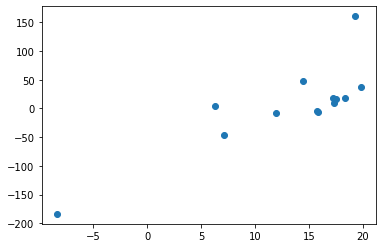

In [9]:
avg_weights = weights.pivot_table(index='end_time', columns='name').mean().xs('amtUSD').drop(['total', 'USDT'])
print(f'leverage = {avg_weights.sum()}')
funding = original_trajectory.pivot_table(index='time', columns='name', values='funding')
averages = pd.DataFrame({'avg_weight_pct': avg_weights*100,
            'avg_funding_pct': funding.mean()*100}).sort_values('avg_weight_pct', key=abs, ascending=False)
plt.scatter(x=averages['avg_funding_pct'], y=averages['avg_weight_pct'])
averages.head(20)

## tracking error

In [10]:
df = copy.deepcopy(original_trajectory)
df = df.set_index('time')
df['tracking_error'] = (df['RealizedCarry']-df['ExpectedCarry'])*8/24/365.25/equity
tracking_error = df.pivot_table(index='time', columns='name', values='tracking_error')
tracking_error.cumsum().iplot(title=f'tracking error')
tracking_error.sum()

name
ADAUSDT     0.002423
ATOMUSDT   -0.009641
BCHUSDT    -0.001613
BNBUSDT    -0.423456
BTCUSDT    -0.000380
EOSUSDT     0.001321
ETCUSDT    -0.000595
ETHUSDT    -0.002181
LINKUSDT    0.000041
LTCUSDT     0.002282
TRXUSDT    -0.012254
USDT       -0.000021
XLMUSDT    -0.000083
XRPUSDT     0.023233
total      -0.420924
dtype: float64

# benchmarks

In [13]:
df = copy.deepcopy(original_trajectory)
df = df[df['name']!='USDT']
df['RealizedCarry'] /= equity
df['carry'] = df.apply(lambda x: max(-x['funding']-x['borrow'],x['funding']), axis=1)
pivot = df.pivot_table(index='time', columns='name')
benchmarks = pd.concat([pivot.xs(['carry'], axis=1), pivot[[('RealizedCarry', 'total')]]], axis=1).droplevel(0, axis=1)
stats = pd.DataFrame()
stats['vs mean'] = (benchmarks['total']-benchmarks.drop(columns='total').mean(axis=1))
stats['vs median'] = (benchmarks['total']-benchmarks.drop(columns='total').median(axis=1))
stats['vs 1sigma'] = stats['vs mean']-benchmarks.drop(columns='total').std(axis=1)
stats['vs BTC'] = (benchmarks['total']-benchmarks['BTCUSDT'])
stats['vs ETH'] = (benchmarks['total']-benchmarks['ETHUSDT'])
stats['vs XRP'] = (benchmarks['total']-benchmarks['XRPUSDT'])
stats.expanding().mean().iplot(title=f'perf vs benchmarks')

/tmp/ipykernel_111039/752176181.py:6: FutureWarning:

Passing lists as key for xs is deprecated and will be removed in a future version. Pass key as a tuple instead.

